In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models
from torch.utils.data import DataLoader, random_split
import os

In [2]:
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA device available")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

CUDA available: True
CUDA version: 12.1
cuDNN version: 8801
Device name: NVIDIA GeForce RTX 3070


In [3]:
transform_train = transforms.Compose([
  transforms.RandomHorizontalFlip(),
  transforms.Resize((224, 224)),
  transforms.Pad(4),
  transforms.RandomCrop((224, 224)),
  transforms.RandomRotation(10),
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
  ])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [4]:
data_dir = 'Larger'
batch_size = 32
num_workers = 8

full_dataset = datasets.ImageFolder(data_dir, transform=transform_train)
train_size = int(0.7 * len(full_dataset))
remaining_size = len(full_dataset) - train_size
val_size = remaining_size // 2
test_size = remaining_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Update the transforms for validation and test datasets
val_dataset.dataset.transform = val_test_transform
test_dataset.dataset.transform = val_test_transform

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [5]:
# Check the distribution of classes in given loader
def calculate_class_image_count_in_loader(loader_name, loader):
    class_counts = {class_name: 0 for class_name in full_dataset.classes}
    for _, labels in loader:
        for label in labels:
            class_counts[full_dataset.classes[label]] += 1

    print(30*'=')
    print(f"Class distribution in {loader_name}_loader:")
    for class_name, count in class_counts.items():
        print(f"{class_name}: {count}")

calculate_class_image_count_in_loader('train', train_loader)
calculate_class_image_count_in_loader('val', val_loader)
calculate_class_image_count_in_loader('test', test_loader)

Class distribution in train_loader:
Coccidiosis: 1457
Healthy: 1433
Newcastle: 269
Salmonella: 1609
Class distribution in val_loader:
Coccidiosis: 323
Healthy: 326
Newcastle: 52
Salmonella: 321
Class distribution in test_loader:
Coccidiosis: 323
Healthy: 298
Newcastle: 55
Salmonella: 346


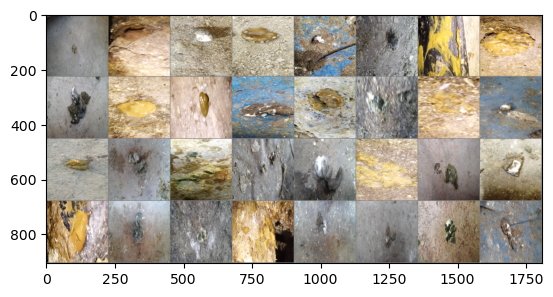

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
  # Unnormalize image
  img = img / 2 + 0.5
  # Convert to numpy objects
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

# Get random training images with iter function
images, labels = next(iter(train_loader))
imshow(torchvision.utils.make_grid(images))

In [7]:
import os

def count_items_in_folder(folder_path):
    try:
        items = os.listdir(folder_path)
        return len(items)
    except FileNotFoundError:
        print(f"The folder {folder_path} does not exist.")
        return 0
    except PermissionError:
        print(f"Permission denied for accessing the folder {folder_path}.")
        return 0

def count_items_in_subfolders(parent_folder_path):
    total_image_count = 0
    try:
        with os.scandir(parent_folder_path) as entries:
            for entry in entries:
                if entry.is_dir():
                    subfolder_path = entry.path
                    item_count = count_items_in_folder(subfolder_path)
                    total_image_count += item_count
                    train_count = int(0.7 * item_count)
                    remaining_count = item_count - train_count
                    val_count = remaining_count // 2
                    test_count = remaining_count - val_count
                    print(f"{subfolder_path}, Total count: {item_count}, Train count: {train_count}, Val count: {val_count}, Test count: {test_count}")
            print(f"Total image count in dataset: {total_image_count}")
    except FileNotFoundError:
        print(f"The folder {parent_folder_path} does not exist.")
    except PermissionError:
        print(f"Permission denied for accessing the folder {parent_folder_path}.")

print(f"Dataset classes: {full_dataset.classes}")
print(100*"=")
count_items_in_subfolders(data_dir)


Dataset classes: ['Coccidiosis', 'Healthy', 'Newcastle', 'Salmonella']
Larger\Coccidiosis, Total count: 2103, Train count: 1472, Val count: 315, Test count: 316
Larger\Healthy, Total count: 2057, Train count: 1439, Val count: 309, Test count: 309
Larger\Newcastle, Total count: 376, Train count: 263, Val count: 56, Test count: 57
Larger\Salmonella, Total count: 2276, Train count: 1593, Val count: 341, Test count: 342
Total image count in dataset: 6812


In [6]:
model = models.efficientnet_b0(pretrained=True)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, len(full_dataset.classes))
print(model)

c:\Users\Lukas\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Lukas\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\Lukas/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 31.8MB/s]

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [7]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('-' * 10)
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(loader.dataset)
            epoch_acc = running_corrects.double() / len(loader.dataset)

            print(f'{phase} phase - Loss: {epoch_loss:.4f} Accuracy: {epoch_acc:.4f}')

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    print(40*'=')
    print(f'Best validation accuracy: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [8]:
lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [9]:
model = model.to(device)
print(f"Training with LR={lr}")
model = train_model(model, criterion, optimizer, train_loader, val_loader)

Training with LR=0.001
----------
Epoch 1/10
----------
train phase - Loss: 0.6797 Accuracy: 0.7894
val phase - Loss: 0.2990 Accuracy: 0.8992
----------
Epoch 2/10
----------
train phase - Loss: 0.2922 Accuracy: 0.9004
val phase - Loss: 0.1889 Accuracy: 0.9462
----------
Epoch 3/10
----------
train phase - Loss: 0.1868 Accuracy: 0.9440
val phase - Loss: 0.1313 Accuracy: 0.9628
----------
Epoch 4/10
----------
train phase - Loss: 0.1390 Accuracy: 0.9597
val phase - Loss: 0.1017 Accuracy: 0.9726
----------
Epoch 5/10
----------
train phase - Loss: 0.1010 Accuracy: 0.9717
val phase - Loss: 0.0820 Accuracy: 0.9765
----------
Epoch 6/10
----------
train phase - Loss: 0.0819 Accuracy: 0.9759
val phase - Loss: 0.0691 Accuracy: 0.9804
----------
Epoch 7/10
----------
train phase - Loss: 0.0644 Accuracy: 0.9836
val phase - Loss: 0.0604 Accuracy: 0.9824
----------
Epoch 8/10
----------
train phase - Loss: 0.0558 Accuracy: 0.9847
val phase - Loss: 0.0587 Accuracy: 0.9824
----------
Epoch 9/10
---

Utility functions for saving and loading model states

In [10]:
torch.save(model.state_dict(), 'poultry_disease_efficientnet-larger.pth')

In [18]:
model.load_state_dict(torch.load('poultry_disease_efficientnet-larger.pth', map_location=device))

<All keys matched successfully>

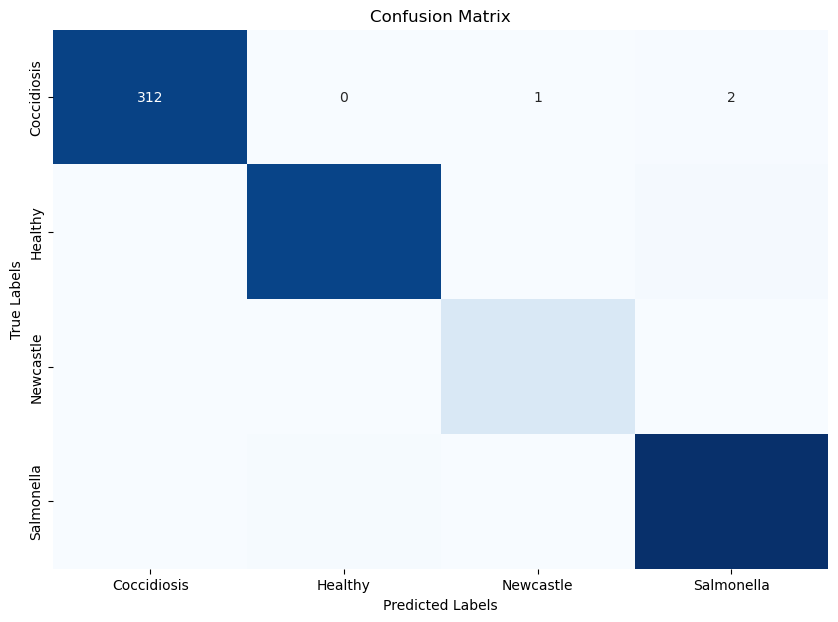

Accuracy: 0.9853
Precision: 0.9855
Recall: 0.9853
F1 Score: 0.9854


In [11]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

true_labels = []
predicted_labels = []

model.eval()
model = model.to(device)
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

conf_matrix = confusion_matrix(true_labels, predicted_labels)

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=full_dataset.classes, yticklabels=full_dataset.classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

print(20*'=')
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

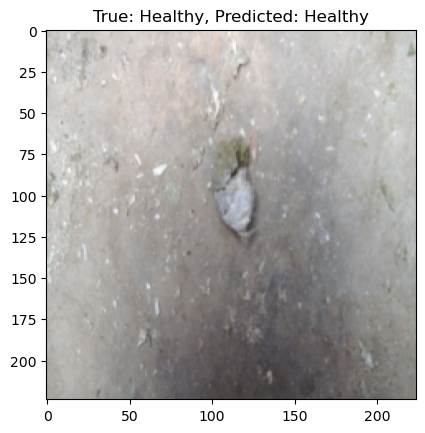

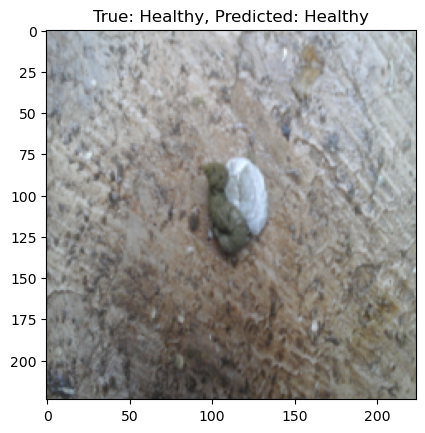

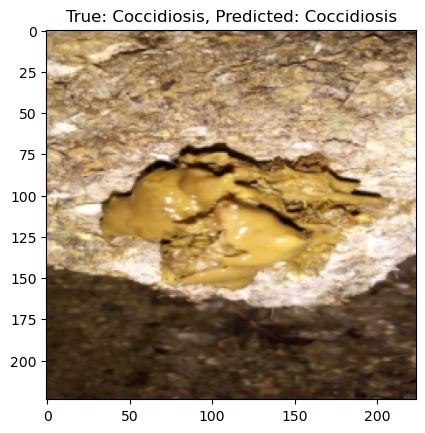

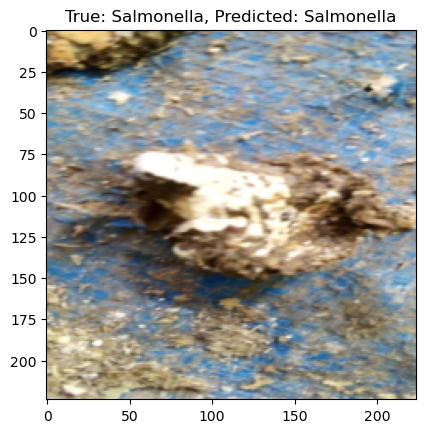

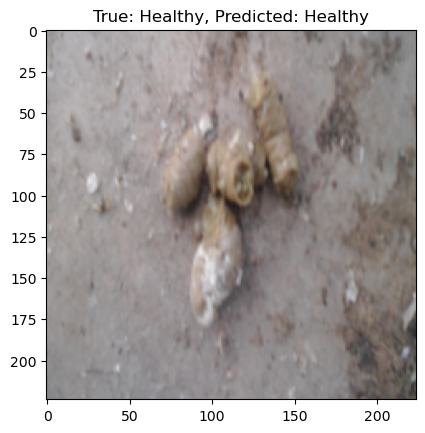

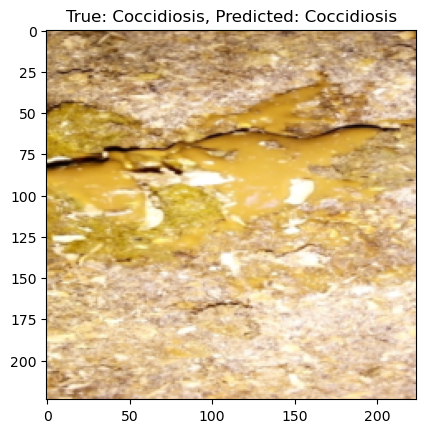

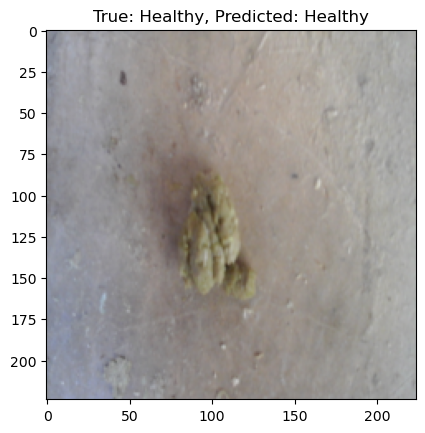

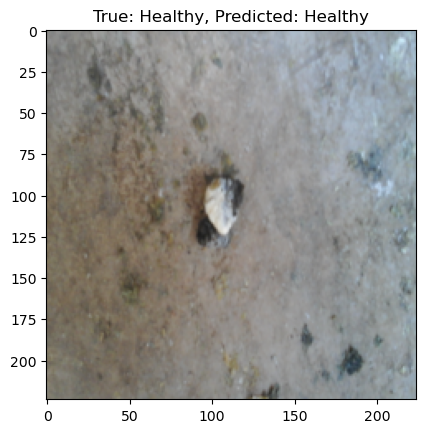

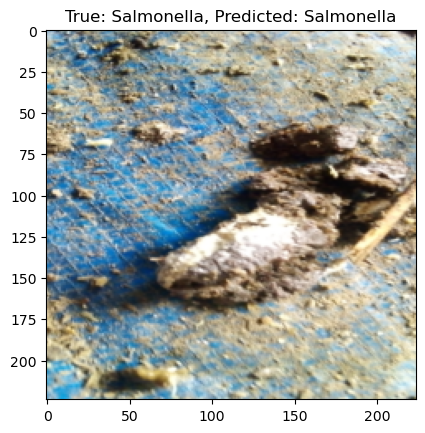

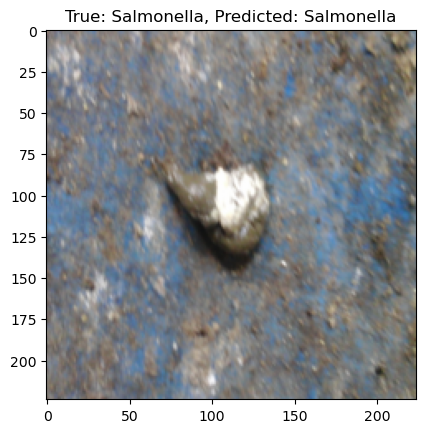

True labels:  ['Healthy', 'Healthy', 'Coccidiosis', 'Salmonella', 'Healthy', 'Coccidiosis', 'Healthy', 'Healthy', 'Salmonella', 'Salmonella', 'Salmonella', 'Coccidiosis', 'Salmonella', 'Healthy', 'Healthy', 'Coccidiosis', 'Healthy', 'Healthy', 'Healthy', 'Coccidiosis', 'Healthy', 'Salmonella', 'Healthy', 'Healthy', 'Healthy', 'Salmonella', 'Coccidiosis', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Salmonella']
Predicted labels:  ['Healthy', 'Healthy', 'Coccidiosis', 'Salmonella', 'Healthy', 'Coccidiosis', 'Healthy', 'Healthy', 'Salmonella', 'Salmonella', 'Salmonella', 'Coccidiosis', 'Salmonella', 'Healthy', 'Healthy', 'Coccidiosis', 'Healthy', 'Healthy', 'Healthy', 'Coccidiosis', 'Healthy', 'Salmonella', 'Healthy', 'Healthy', 'Healthy', 'Salmonella', 'Coccidiosis', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Salmonella']


In [13]:
# Get a batch of data from the test_loader
data_iter = iter(test_loader)
images, labels = next(data_iter)

images = images.to(device)
labels = labels.to(device)

model.eval()
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Move labels and predictions back to CPU
images = images.cpu()
labels = labels.cpu()
predicted = predicted.cpu()

# Function to show an image
def imshow(img, title=None):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.show()

# Display a few images with true and predicted labels
number_of_images_to_show = 10
for i in range(min(number_of_images_to_show, len(images))):
    imshow(images[i], title=f"True: {full_dataset.classes[labels[i]]}, Predicted: {full_dataset.classes[predicted[i]]}")

# Print true and predicted labels for a single batch
print("True labels: ", [full_dataset.classes[labels[i]] for i in range(len(labels))])
print("Predicted labels: ", [full_dataset.classes[predicted[i]] for i in range(len(predicted))])